![Colegio Bourbaki](./Images/Bourbaki.png)

## Machine Learning

### Dynamic Pricing

### Contexto

Una empresa de viajes compartidos quiere implantar una estrategia de precios dinámica para optimizar las tarifas en función de las condiciones del mercado en tiempo real. Actualmente, la empresa sólo utiliza la duración del trayecto para decidir las tarifas. La empresa quiere aprovechar las técnicas basadas en datos para analizar los datos históricos y desarrollar un modelo predictivo que pueda ajustar dinámicamente los precios en respuesta a factores cambiantes.

Se ha proporcionado un conjunto de datos que contiene datos históricos de viajes. El conjunto de datos incluye características como el número de pasajeros, el número de conductores, la categoría de ubicación, el estado de fidelidad del cliente, el número de trayectos anteriores, las valoraciones medias, la hora de la reserva, el tipo de vehículo, la duración prevista del trayecto y el coste histórico de los trayectos.

Su objetivo es construir un modelo de precios dinámico que incorpore las características proporcionadas para predecir las tarifas óptimas de los viajes en tiempo real. El modelo debe tener en cuenta factores como los patrones de demanda y la disponibilidad de la oferta.

Link: https://www.kaggle.com/datasets/arashnic/dynamic-pricing-dataset?select=dynamic_pricing.csv

### Librerías

In [1]:
# Data Analysis
import pandas as pd

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import numpy as np

### Carga de Datos

In [2]:
df=pd.read_csv('./Data/dynamic_pricing.csv')

In [3]:
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


### Análisis Exploratorio

Vamos a ver la distribución de las variables numéricas y categóricas.

Primero, las numéricas:

In [5]:
numerical_cols = ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides', 
                  'Average_Ratings', 'Expected_Ride_Duration', 'Historical_Cost_of_Ride']

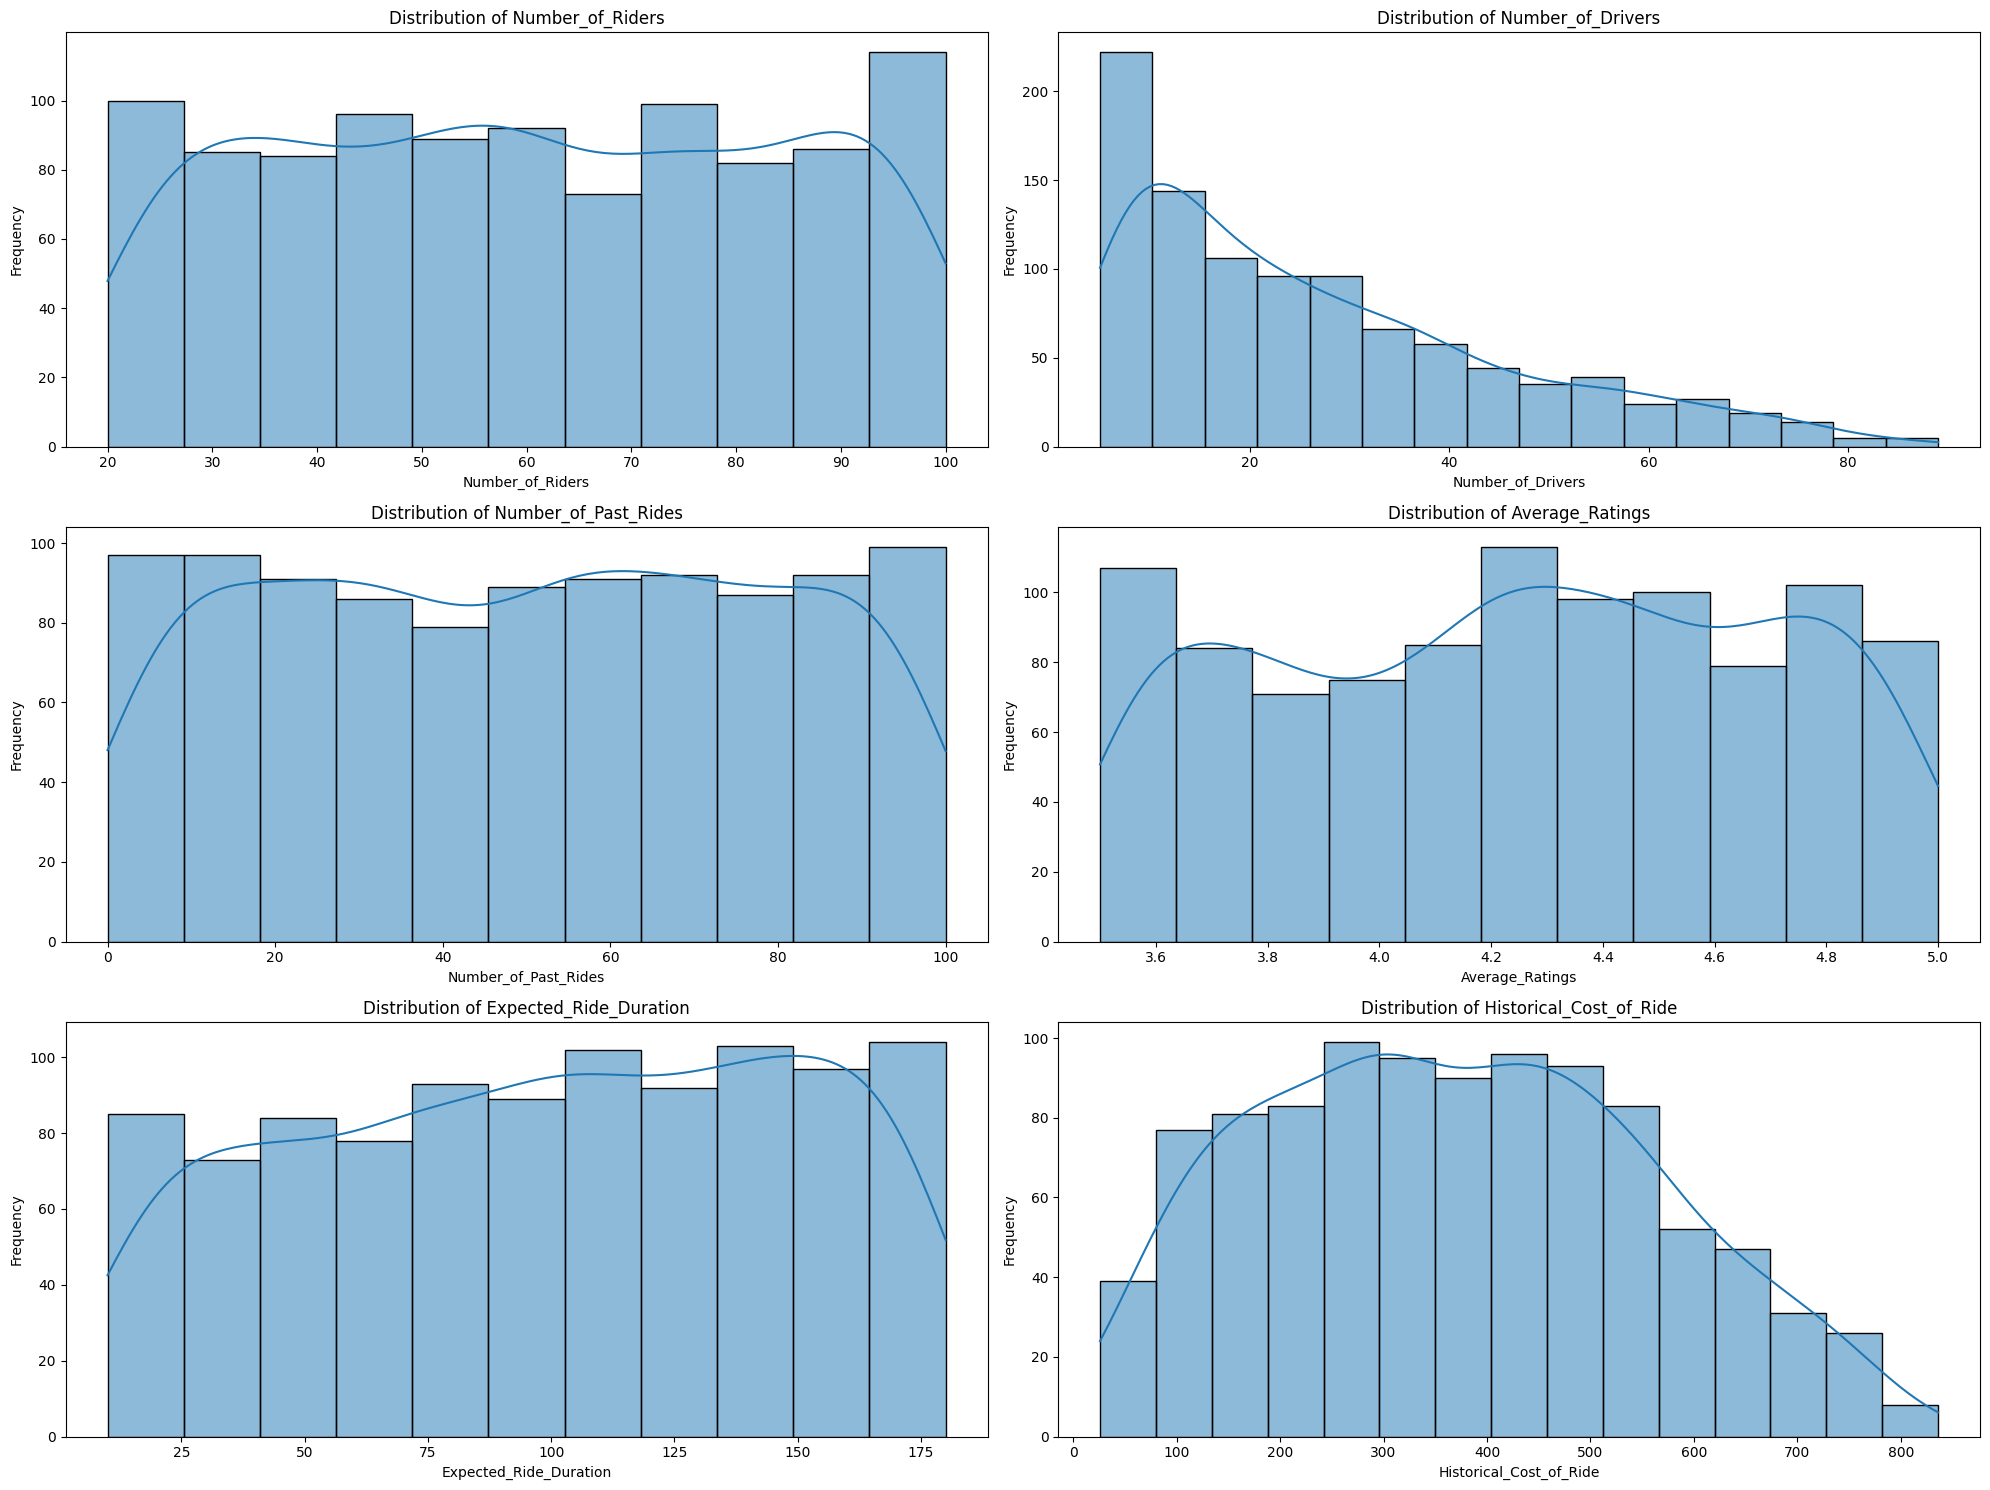

In [6]:
# Determine the layout of subplots
n_cols = 2
n_rows = len(numerical_cols) // n_cols + (len(numerical_cols) % n_cols > 0)

# Create a figure and a grid of subplots
plt.figure(figsize=(20, 5 * n_rows))

for i, column in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [7]:
df[numerical_cols].describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


Ahora, las categóricas:

In [8]:
# Relationship between categorical features and Historical Cost of Ride
categorical_cols = ['Location_Category', 'Customer_Loyalty_Status', 
                    'Time_of_Booking', 'Vehicle_Type']

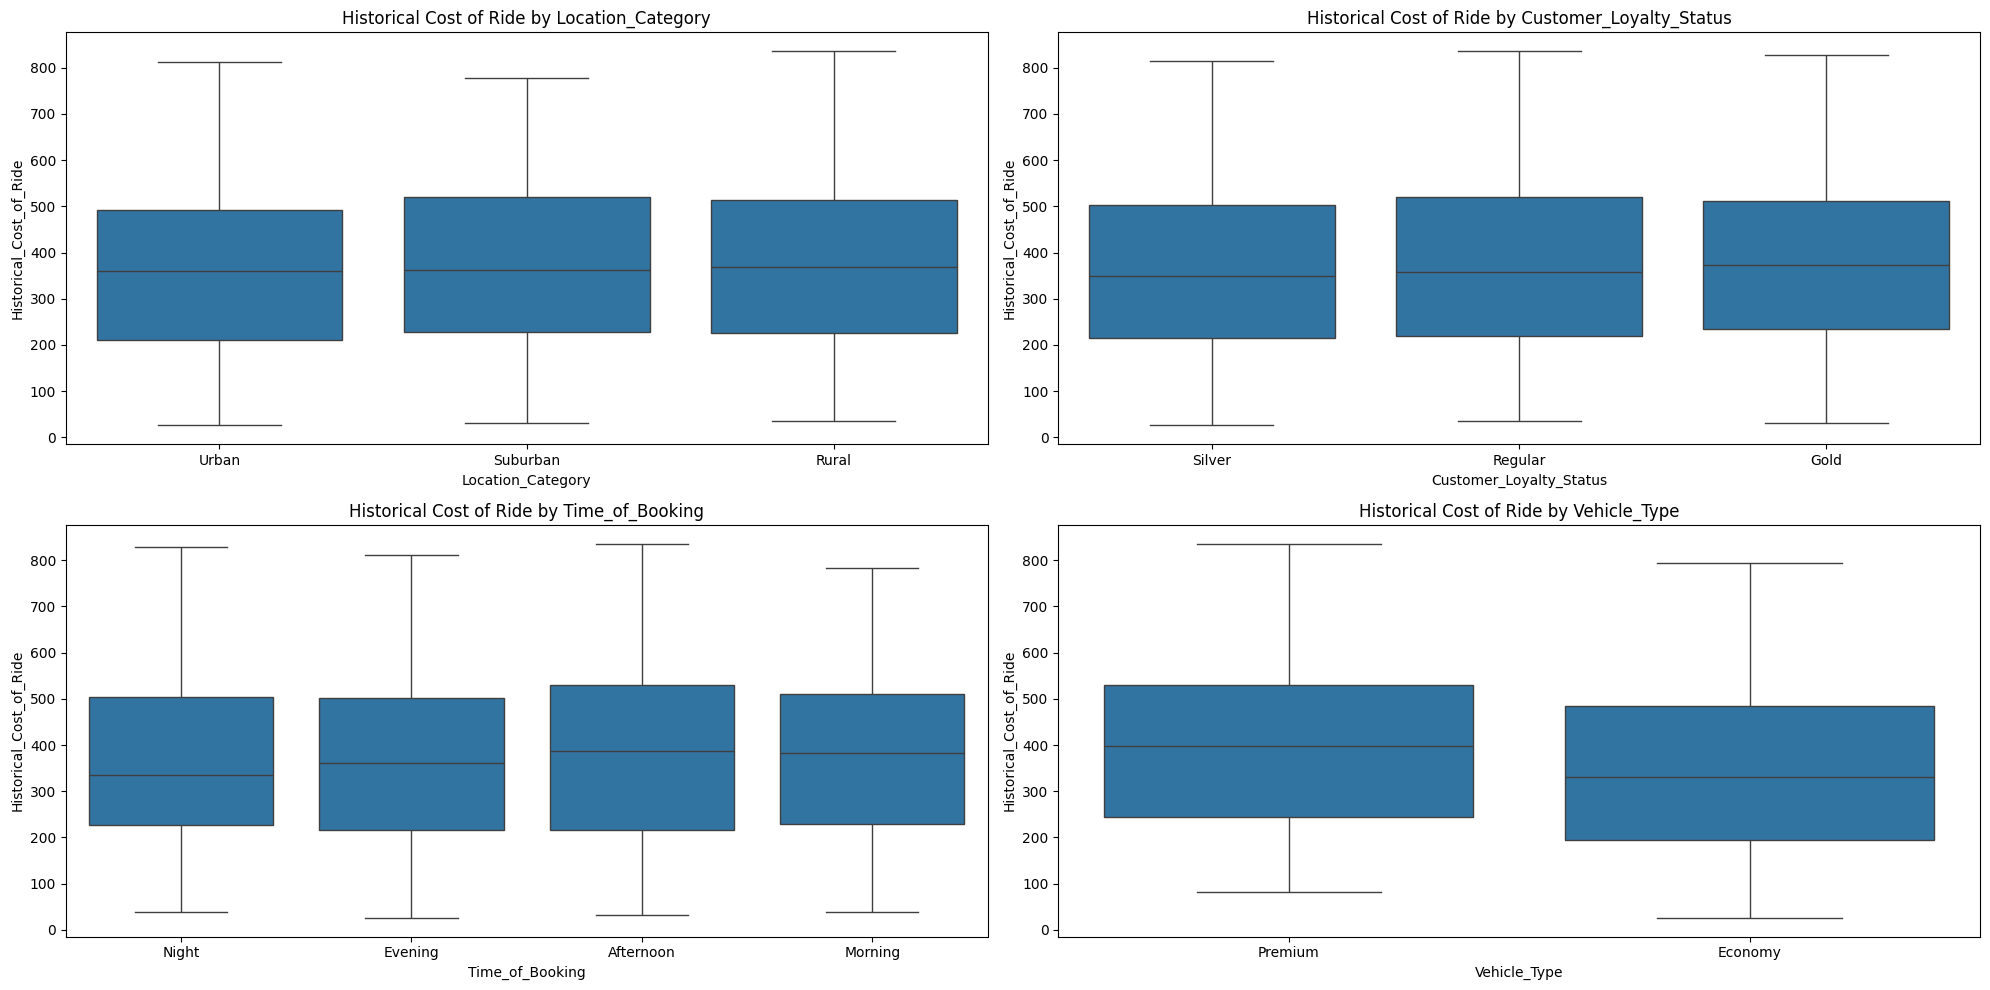

In [9]:
n_rows = len(categorical_cols) // n_cols + (len(categorical_cols) % n_cols > 0) 

plt.figure(figsize=(20, 5 * n_rows))

for i, column in enumerate(categorical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=column, y='Historical_Cost_of_Ride', data=df)
    plt.title(f'Historical Cost of Ride by {column}')

plt.tight_layout()
plt.show()

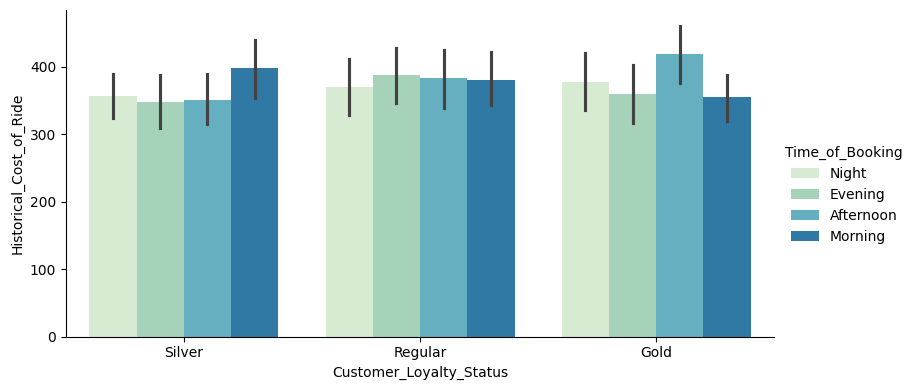

In [10]:
sns.catplot(data=df, x="Customer_Loyalty_Status", y="Historical_Cost_of_Ride", hue="Time_of_Booking", kind="bar", height=4, aspect=2, palette= 'GnBu')
plt.show()

#### Preprocesamiento

Vamos a normalizar las variables numéricas y codificar las variables categóricas:

In [11]:
# Creating transformers for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Fitting the preprocessor and transforming the dataset
df_processed_array = preprocessor.fit_transform(df)

# Getting feature names for the transformed dataset
feature_names = (numerical_cols + 
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)))

# Converting the processed array back to a dataframe
df_processed = pd.DataFrame(df_processed_array, columns=feature_names)

# Display the processed dataframe
df_processed.head()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride,Location_Category_Rural,Location_Category_Suburban,Location_Category_Urban,Customer_Loyalty_Status_Gold,Customer_Loyalty_Status_Regular,Customer_Loyalty_Status_Silver,Time_of_Booking_Afternoon,Time_of_Booking_Evening,Time_of_Booking_Morning,Time_of_Booking_Night,Vehicle_Type_Economy,Vehicle_Type_Premium
0,0.8750,0.476190,0.13,0.646667,0.470588,0.318796,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.4750,0.404762,0.72,0.373333,0.194118,0.182542,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.2750,0.309524,0.00,0.326667,0.388235,0.375007,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.8625,0.273810,0.67,0.540000,0.729412,0.548321,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.7250,0.202381,0.74,0.180000,0.817647,0.683462,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Observemos la matrix de correlación:

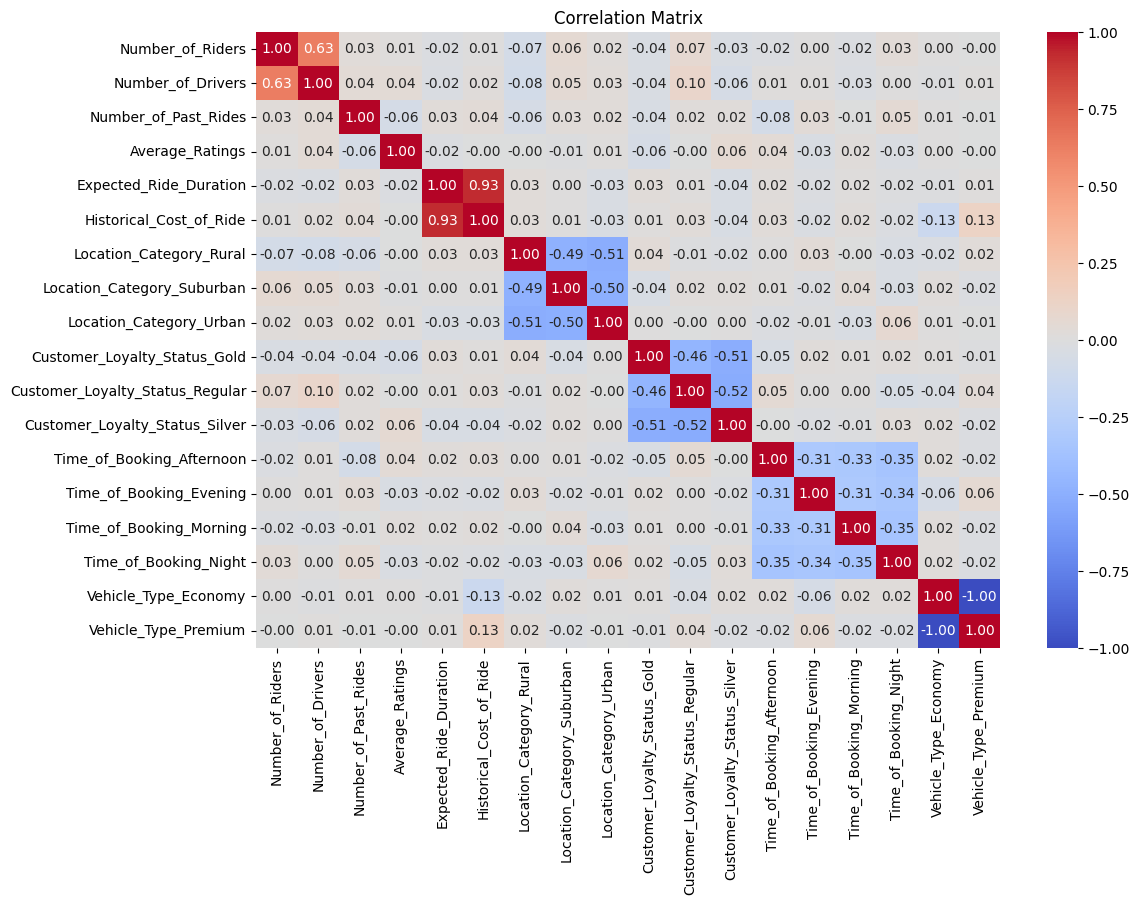

In [12]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_processed.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

En este caso, no haremos feature selection, aunque si podriamos entre Expected_Ride_Duration y Historical_Cost_of_Ride, lo cual parece bastante lógico.

### Q-Learning: Algoritmo de aprendizaje

![RL](./Images/rl.jpg)

El algoritmo Q-learning es un método de aprendizaje por refuerzo que permite a un agente aprender a tomar decisiones óptimas para alcanzar un objetivo en un entorno determinado. Q-Learning fue introducido por Chris Watkins en 1989. Watkins y Peter Dayan presentaron una prueba de convergencia en 1992.

El objetivo del Q-learning es aprender una política de acciones que maximice la suma total de recompensas recibidas a lo largo del tiempo.

**Componentes principales del Q-learning:**

* **Agente:** Entidad que aprende a tomar decisiones basadas en el estado del entorno.
* **Entorno:** El mundo con el que interactúa el agente, que incluye estados y recompensas.
* **Estados:** Representaciones del entorno en un momento dado.
* **Acciones:** Las diferentes operaciones que el agente puede realizar en el entorno.
* **Recompensas:** Valor que el agente recibe después de tomar una acción en un estado específico, indicando el éxito o fracaso de esa acción.

Funcionamiento del Q-learning:

1) **Inicialización:** Se crea una tabla Q inicializada con ceros (o valores aleatorios pequeños), donde las filas representan los estados y las columnas las acciones. Los valores Q representan la calidad de una acción específica tomada en un estado específico.

2) **Interacción con el entorno:** En cada episodio de entrenamiento, el agente toma acciones en el entorno, observa las recompensas recibidas y actualiza los valores Q en la tabla Q basándose en esas recompensas y las estimaciones futuras de recompensas.

3) **Política de acción:** El agente utiliza una política (como ε-greedy) para explorar el entorno tomando acciones aleatorias con una probabilidad ε o explotar el conocimiento actual eligiendo la acción con el mayor valor Q para el estado actual con una probabilidad de 1-ε. Esto equilibra la exploración de nuevas acciones con la explotación de acciones conocidas que maximizan las recompensas.

4) **Actualización de la tabla Q:** Después de cada acción, la tabla Q se actualiza utilizando la ecuación de actualización de Q-learning:

$Q(s,a)=Q(s,a)+α[r+γ max_{a^′}​Q(s^′,a^′)−Q(s,a)]$

Donde:

* $Q(s,a)$: El valor Q actual para el estado $s$ y la acción $a$.
* $α$: Tasa de aprendizaje.
* $r$: Recompensa recibida por tomar la acción aa en el estado $s$.
* $γ$: Factor de descuento para las recompensas futuras.
* $max⁡_{a′}Q(s^′,a^′)$: La mejor estimación de valor Q para el próximo estado $s^′$.

![Q-equation](./Images/Qequation.png)

**Convergencia:**

Con suficiente interacción y actualización, la tabla Q converge hacia los valores óptimos, permitiendo que el agente tome las mejores decisiones para maximizar las recompensas totales a lo largo del tiempo.

El Q-learning es un algoritmo poderoso y flexible para el aprendizaje por refuerzo que no requiere un modelo del entorno, lo que lo hace adecuado para una amplia gama de aplicaciones, desde juegos hasta problemas de decisión en entornos complejos y dinámicos.

**Estados**

El estado debe encapsular la situación actual que podría afectar a las decisiones de fijación dinámica de precios. Un estado completo podría ser una combinación de las siguientes características:

* Location_Category: Categórica (Urbana, Suburbana, Rural)
* Customer_Loyalty_Status: Categórico (Normal, Plata, Oro)
* Time_of_Booking: Categórica (Mañana, Tarde, Noche)
* Vehicle_Type: Categórico (Económico, Premium)
    
Una representación simplificada del Number_of_Riders y Number_of_Drivers, posiblemente categorizada en baja, media y alta para reducir la complejidad del espacio de estados.

**Acciones**

Las acciones pueden implicar el establecimiento de diferentes niveles de precios. Para simplificar, podemos definir las acciones como ajustes del precio base:

* Aumentar el precio en un porcentaje determinado (por ejemplo, 10%, 20%)
* Disminuir el precio en un porcentaje determinado (por ejemplo, 10%, 20%)
* Mantener el precio sin cambios

**Recompensas**

La estructura de recompensas podría basarse en maximizar el beneficio manteniendo o mejorando la satisfacción del cliente. Una recompensa sencilla podría definirse del siguiente modo:

* Recompensa positiva por un viaje reservado al precio ajustado, modificada además por el estado de fidelidad del cliente (mayores recompensas para los clientes fieles).
* Recompensa negativa si no se produce ninguna reserva en un plazo determinado tras el ajuste de precios.
* Recompensas adicionales por mantener o mejorar la valoración media dentro de una categoría de viajes.

**Implementación**

Dada esta configuración, el algoritmo de aprendizaje Q aprenderá iterativamente la mejor acción (ajuste de precios) a tomar en cada estado (condiciones actuales del mercado) para maximizar la recompensa a largo plazo (beneficio y satisfacción del cliente).

Empecemos simplificando y codificando las características para definir los estados, y luego podremos simular un entorno de aprendizaje Q para optimizar la estrategia de precios. Debido a la complejidad de la fijación dinámica de precios en tiempo real, nuestra simulación será un modelo simplificado.

In [13]:
# Simplify and encode features for states
# Categorize 'Number_of_Riders' and 'Number_of_Drivers' into low (0), medium (1), and high (2) categories
df['Riders_Category'] = pd.qcut(df['Number_of_Riders'], 3, labels=False)
df['Drivers_Category'] = pd.qcut(df['Number_of_Drivers'], 3, labels=False)

# Normalize 'Expected_Ride_Duration' and 'Historical_Cost_of_Ride'
scaler = MinMaxScaler()
df[['Expected_Ride_Duration_Norm', 'Historical_Cost_of_Ride_Norm']] = scaler.fit_transform(df[['Expected_Ride_Duration', 'Historical_Cost_of_Ride']])

# Select and encode features for the state definition
state_features = ['Location_Category', 'Customer_Loyalty_Status', 'Time_of_Booking', 'Vehicle_Type', 'Riders_Category', 'Drivers_Category']
df_state_encoded = pd.get_dummies(df[state_features])

In [14]:
# Overview of the prepared state features
df_state_encoded.head()

,Riders_Category,Drivers_Category,Location_Category_Rural,Location_Category_Suburban,Location_Category_Urban,Customer_Loyalty_Status_Gold,Customer_Loyalty_Status_Regular,Customer_Loyalty_Status_Silver,Time_of_Booking_Afternoon,Time_of_Booking_Evening,Time_of_Booking_Morning,Time_of_Booking_Night,Vehicle_Type_Economy,Vehicle_Type_Premium
0,2,2,False,False,True,False,False,True,False,False,False,True,False,True
1,1,2,False,True,False,False,False,True,False,True,False,False,True,False
2,0,1,True,False,False,False,False,True,True,False,False,False,False,True
3,2,1,True,False,False,False,True,False,True,False,False,False,False,True
4,2,1,True,False,False,False,True,False,True,False,False,False,True,False


Los siguientes pasos consisten en configurar el algoritmo de aprendizaje Q, que incluye:

* Inicializar la tabla Q: Una tabla en la que las filas corresponden a los estados y las columnas a las acciones. Inicialmente, esta tabla se rellena con ceros.
* Definir la tasa de aprendizaje, el factor de descuento y la política de exploración (por ejemplo, el método ε-greedy).
* Implementar el proceso de aprendizaje, en el que el agente (estrategia de precios) interactúa con el entorno (condiciones del mercado), realiza acciones (ajusta los precios) y actualiza los valores Q en función de las recompensas recibidas.

Para simular el entorno e implementar el algoritmo Q-learning para la fijación dinámica de precios, seguiremos los siguientes pasos:

* Simular el entorno: Definir una función que simule la respuesta del mercado a diferentes acciones de fijación de precios. Esta función proporcionará recompensas basadas en la acción realizada en un estado determinado.

* Calcular la recompensa: Defina una función de recompensa que calcule la recompensa por tomar una determinada acción en un estado específico, considerando factores como la satisfacción del cliente y el margen de beneficio.

* Implementar Q-Learning: Configurar el algoritmo Q-learning, incluyendo la inicialización de la tabla Q, la definición de la tasa de aprendizaje (alfa), el factor de descuento (gamma), y la estrategia de exploración (por ejemplo, epsilon-greedy).

Paso 1: Simular el entorno

Esta función simula cómo reacciona el mercado (los clientes) ante una decisión de fijación de precios. La respuesta se simplifica a una reserva con éxito (recompensa positiva) o a una oportunidad perdida (recompensa negativa), influida por factores como el equilibrio entre la oferta y la demanda, la fidelidad del cliente y el momento de la reserva.

Paso 2: Calcular la recompensa

La función de recompensa calculará el beneficio o la pérdida por realizar una acción, teniendo en cuenta el precio base, el coste histórico del trayecto y el estado de fidelidad del cliente para ajustar la recompensa en consecuencia.

Paso 3: Implementar Q-Learning

Inicializaremos la tabla Q e implementaremos el proceso de aprendizaje, en el que el agente actualiza iterativamente los valores Q basándose en las recompensas observadas por realizar acciones en diferentes estados.

In [15]:
def simulate_environment(state, action, data):
    """
    Simulates the environment response to an action.
    - state: The current state represented by an index of the state_features dataframe.
    - action: The action taken (0: decrease price, 1: keep price unchanged, 2: increase price).
    - data: The dataset containing the environment and market information.
    
    Returns a reward based on the action's outcome.
    """
    # Simplified simulation: positive reward for bookings, negative for no booking
    # Assuming higher demand in Urban areas and for loyal customers (Gold status)
    location_urban = data.iloc[state]['Location_Category_Urban']
    loyalty_gold = data.iloc[state]['Customer_Loyalty_Status_Gold']
    
    # Basic reward logic based on demand-supply dynamics and customer loyalty
    base_reward = 10 if location_urban else 5  # Higher base reward in urban areas
    loyalty_bonus = 5 if loyalty_gold else 0  # Bonus reward for loyal customers
    
    # Adjust reward based on action
    if action == 0:  # Decrease price
        reward = base_reward - 2 + loyalty_bonus
    elif action == 1:  # Keep price unchanged
        reward = base_reward + loyalty_bonus
    else:  # Increase price
        reward = base_reward - 5 + loyalty_bonus  # Risk of losing customers with higher prices
    
    return reward

El paso 2 esta incluido en la función simulate_environment.

In [16]:
# Step 3: Implement Q-Learning
def q_learning(data, episodes, learning_rate, gamma, epsilon, min_epsilon, epsilon_decay):
    """
    Adapted Q-learning algorithm with specified parameters.
    - data: The dataset representing the state space.
    - episodes: The number of episodes to run the simulation.
    - learning_rate: The learning rate (alpha).
    - gamma: The discount factor for future rewards.
    - epsilon: The initial exploration rate for epsilon-greedy policy.
    - min_epsilon: The minimum exploration rate.
    - epsilon_decay: The decay rate of epsilon after each episode.
    
    Returns the Q-table and epsilon values over episodes.
    """
    num_states = data.shape[0]
    num_actions = 3  # Defined actions: decrease price, keep unchanged, increase price
    
    # Initialize Q-table with zeros
    Q = np.zeros((num_states, num_actions))
    epsilon_values = []  # To track the decay of epsilon over episodes
    
    for episode in range(episodes):
        state = np.random.randint(0, num_states-1)  # Start from a random state
        done = False
        
        while not done:
            # Epsilon-greedy action selection
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, num_actions-1)  # Explore action space
            else:
                action = np.argmax(Q[state])  # Exploit learned values
            
            # Simulate environment and get reward
            reward = simulate_environment(state, action, data)
            
            # Assume next state randomly for simplicity (in a real scenario, this would be determined by the action's outcome)
            next_state = np.random.randint(0, num_states-1)
            
            # Update Q-value using the Q-learning formula
            old_value = Q[state, action]
            next_max = np.max(Q[next_state])
            
            # Q-learning formula
            new_value = old_value + learning_rate * (reward + gamma * next_max - old_value)
            Q[state, action] = new_value
            
            # Update state (in a real scenario, the episode would end based on certain conditions)
            state = next_state
            done = True  # End the episode after one iteration for simplicity
        
        # Update epsilon with decay
        epsilon = max(min_epsilon, epsilon - epsilon_decay)
        epsilon_values.append(epsilon)
    
    return Q, epsilon_values

In [17]:
# Parameters
learning_rate = 0.01
gamma = 0.95
epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 0.01
episodes = 1000

In [18]:
# Apply Q-Learning on the encoded state space
Q_table, epsilon_values = q_learning(df_state_encoded, episodes, learning_rate, gamma, epsilon, min_epsilon, epsilon_decay)

El algoritmo de aprendizaje Q se ha aplicado al entorno simulado, y como resultado hemos obtenido una tabla Q. La tabla Q representa los valores aprendidos para tomar determinadas acciones en estados específicos. Estos valores guían al agente (estrategia de precios dinámica) a la hora de decidir qué acción tomar en cada estado para maximizar la recompensa a largo plazo.

En la tabla Q:

* Cada fila corresponde a un estado en el espacio de estados codificado.
* Cada columna corresponde a una de las tres acciones: disminuir el precio, mantener el precio sin cambios o aumentar el precio.

Los valores de la tabla representan la recompensa esperada a largo plazo por realizar una acción determinada en un estado determinado, tal y como se ha aprendido a través del proceso de aprendizaje Q.

In [19]:
epsilon_values[:10] 

[0.99,
 0.98,
 0.97,
 0.96,
 0.95,
 0.94,
 0.9299999999999999,
 0.9199999999999999,
 0.9099999999999999,
 0.8999999999999999]

In [20]:
Q_table

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.05998748, 0.        , 0.        ],
       ...,
       [0.08      , 0.        , 0.        ],
       [0.03      , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

La tasa de exploración (epsilon) comenzó en 1,0 y decayó en 0,01 después de cada episodio, como se muestra en los 10 primeros valores de epsilon:

Epsilon inicial: 1,0
Después del 1er episodio: 0.99
Después del 2º episodio 0.98 ...
Después del 10º episodio 0.9

Este descenso en la tasa de exploración garantiza que el algoritmo pase gradualmente de explorar el espacio de acciones a explotar los valores Q aprendidos a medida que adquiere más experiencia.

La tabla Q muestra los valores Q aprendidos para realizar determinadas acciones en estados específicos. Por ejemplo, los valores de la tabla Q indican las recompensas esperadas a largo plazo por reducir el precio, mantenerlo sin cambios o aumentarlo en diferentes condiciones de mercado. Estos valores guían la estrategia de precios dinámicos para optimizar la toma de decisiones en términos de rentabilidad y satisfacción del cliente.

Con el modelo de aprendizaje Q entrenado, ahora podemos utilizar esta tabla Q para tomar decisiones de fijación de precios en tiempo real eligiendo la acción con el valor Q más alto para el estado actual, ajustando así dinámicamente los precios en función de la dinámica de mercado aprendida.

La aplicación anterior es una simulación simplificada del problema de fijación dinámica de precios. La función simulate_environment modela la respuesta del mercado a las acciones de fijación de precios con lógica básica, recompensando acciones basadas en suposiciones simplificadas sobre las preferencias de los clientes y la dinámica del mercado. La función q_learning actualiza iterativamente la tabla Q basándose en estas interacciones simuladas.

In [21]:
total_revenue_ql = 0
total_rides_ql = 0

In [22]:
for state_id in range(df_state_encoded.shape[0]):
    # Retrieve the best action for the current state from the Q-table
    action_index = np.argmax(Q_table[state_id])
    adjustment = (action_index - 1) * 0.1  # Adjusting the formula to match our action mapping
    
    # Retrieve the historical cost of the ride from the original dataset
    historical_cost = df.iloc[state_id]['Historical_Cost_of_Ride']
    
    # Calculate the adjusted price based on the selected action
    adjusted_price = historical_cost * (1 + adjustment)
    
    # Simplified acceptance model: higher probability of acceptance for smaller adjustments
    accept_probability = max(0, 1 - abs(adjustment))  # Adjust for more realistic probability calculation
    
    # Simulate whether the ride would be accepted based on the adjusted price
    if np.random.rand() < accept_probability:
        total_revenue_ql += adjusted_price
        total_rides_ql += 1

In [23]:
# Calculate the average revenue per ride
average_revenue_per_ride_ql = total_revenue_ql / total_rides_ql if total_rides_ql > 0 else 0

In [24]:
# Display the results
print(f"Total Revenue: ${total_revenue_ql:.3f}, Total Rides: {total_rides_ql}, Average Revenue per Ride: ${average_revenue_per_ride_ql:.2f}")

Total Revenue: $303393.997, Total Rides: 897, Average Revenue per Ride: $338.23


In [25]:
# Calculate the total revenue, total rides, and average revenue per ride based on historical data
total_revenue_historical = df['Historical_Cost_of_Ride'].sum()
total_rides_historical = df.shape[0]
average_revenue_per_ride_historical = total_revenue_historical / total_rides_historical if total_rides_historical > 0 else 0

In [26]:
print(f"Total Revenue: ${total_revenue_historical:.3f}, Total Rides: {total_rides_historical}, Average Revenue per Ride: ${average_revenue_per_ride_historical:.2f}")

Total Revenue: $372502.623, Total Rides: 1000, Average Revenue per Ride: $372.50


In [27]:
# Creating a DataFrame to compare the results of the Q-learning approach and historical data
comparison_data = {
    "Metric": ["Total Revenue", "Total Rides", "Average Revenue per Ride"],
    "Historical Data": [total_revenue_historical, total_rides_historical, average_revenue_per_ride_historical],
    "Q-Learning": [total_revenue_ql, total_rides_ql, average_revenue_per_ride_ql]
}

comparison_df = pd.DataFrame(comparison_data)

# Formatting the "Total Revenue" and "Average Revenue per Ride" for display
comparison_df['Historical Data'] = comparison_df.apply(lambda row: f"${row['Historical Data']:.2f}" if row['Metric'] != "Total Rides" else int(row['Historical Data']), axis=1)
comparison_df['Q-Learning'] = comparison_df.apply(lambda row: f"${row['Q-Learning']:.2f}" if row['Metric'] != "Total Rides" else int(row['Q-Learning']), axis=1)


In [28]:
comparison_df

,Metric,Historical Data,Q-Learning
0,Total Revenue,$372502.62,$303394.00
1,Total Rides,1000,897
2,Average Revenue per Ride,$372.50,$338.23


De la comparación entre los resultados de Q-learning y los datos históricos se desprende que el modelo Q-learning, en su aplicación actual, no ha mejorado los ingresos totales ni los ingresos medios por trayecto. Hay que tener en cuenta algunos puntos a la hora de interpretar estos resultados:

* Simplificación del modelo: El modelo Q-learning actual y la simulación del entorno están simplificados. No se tienen en cuenta factores del mundo real como el comportamiento de los clientes, los precios de la competencia y acontecimientos externos (como vacaciones o condiciones meteorológicas) que podrían afectar significativamente a la demanda y a las estrategias de precios.

* Ajuste de parámetros: El rendimiento del aprendizaje Q depende en gran medida del ajuste de parámetros como la tasa de aprendizaje, el factor de descuento, la tasa de exploración (épsilon) y la tasa de decaimiento de épsilon. El ajuste de estos parámetros puede dar lugar a resultados diferentes.

* Representación de características y espacio de estados: La forma en que se definen y codifican los estados puede tener un impacto sustancial en el proceso de aprendizaje. Considerar características más detalladas o ajustar la forma en que se categorizan las características podría mejorar la capacidad del modelo para aprender estrategias eficaces de fijación de precios.

* Función de recompensa: El diseño de la función de recompensa desempeña un papel fundamental a la hora de guiar el proceso de aprendizaje. La simulación de recompensa actual es básica y podría no captar todos los matices de la satisfacción del cliente y la rentabilidad.

* Exploración vs. Explotación: El equilibrio entre la exploración de nuevas acciones y la explotación de estrategias conocidas es crucial. Es posible que el modelo actual no haya explorado suficientes alternativas o haya explotado acciones subóptimas debido a la estrategia de decaimiento épsilon.


### Ejercicio

* Entrenar el agente Q-learning para maximizar la recompensa de la simulación considerando los puntos anteriores. Empezar por lo más simple (Parameter Fine-Tunning) a estrategias más complejas y reales de estados, acciones y recompensas.

### Referencias

* A Beginners Guide to Q-Learning: https://towardsdatascience.com/a-beginners-guide-to-q-learning-c3e2a30a653c

* Knowledge transfer in Reinforcement Learning ...can RL be a little easier?: https://regressionist.github.io/2019-05-13-Reinforcement-Learning/

#### Artículos de interés

* DeepMind AI Reduces Google Data Centre Cooling Bill by 40%: https://deepmind.google/discover/blog/deepmind-ai-reduces-google-data-centre-cooling-bill-by-40/

![Colegio Bourbaki](./Images/Matematicas.png)

![Colegio Bourbaki](./Images/Contacto.png)